In [1]:
import sys
import os
from copy import deepcopy

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
import wandb

sys.path.append('..')

from src.configs import DataConfig, NetConfig, NetArchitecture, FilterConfig, DataType, CNNConfig, LC_SIZE, ResNetConfig
from src.utils import train, get_wandb_logger
from src.configs import PACKAGE_PATH
from src.data.data_processor import DataProcessor
from src.sweeps.sweep import DATA_CONFIG
from src.module.lightning_module import LCModule
from src.configs import AugmentType as A
from src.module.resnet import resnet20
from src.configs import RB_NAMES, RB_REGEXES, SplitStrategy as ST, DatasetType as DST
from src.data.filters import filter_data

import torch
import numpy as np
import random

In [29]:
data_cfg = DataConfig(
        path=f"{PACKAGE_PATH}/Fall_2021_csv",
        output_path=f"{PACKAGE_PATH}/resources/datasets",
        class_names=RB_NAMES,
        regexes=RB_REGEXES,
        validation_split=0.2,
        split_strategy=ST.TRACK_ID,
        number_of_training_examples_per_class=100_000,
        filter_config=FilterConfig(n_bins=30, n_gaps= 3, gap_size=5, rms_ratio= 0., non_zero_ratio=0.8),
        data_types=[DataType.FS],
        wavelet_start_scale=1,
        wavelet_scales_step=1,
        wavelet_end_scale=5,
        wavelet_name= 'gaus1',
        lc_shifts = 0,
        convert_to_mag=False,
        train_augmentations=[],
)
dp = DataProcessor(data_cfg)

if os.path.exists(f'{dp.output_path}/{dp.hash}'):
    dp.load_data_from_file()
else:
    dp.create_dataset_from_csv()
    dp.save_data()


(X_train, y_train), (X_val, y_val), _ = dp.prepare_dataset()

X = np.concatenate([X_train, X_val])
y = np.concatenate([y_train, y_val])

for i in range(len(data_cfg.class_names)):
    print(f"{data_cfg.class_names[i]}: {np.sum(y == i)}")


Hash: e59449b4d7f03b93ea9173c33eb15318



Splitting CZ-3B: 100%|██████████| 1250/1250 [00:00<00:00, 39154.02it/s]

Splitting Falcon 9: 100%|██████████| 355/355 [00:00<00:00, 18660.04it/s]

Splitting Atlas 5 Centaur: 100%|██████████| 399/399 [00:00<00:00, 14895.92it/s]

Splitting H2-A: 100%|██████████| 352/352 [00:00<00:00, 12597.23it/s]

Splitting Ariane 5: 100%|██████████| 13/13 [00:00<00:00, 8926.97it/s]

Splitting Delta 4: 100%|██████████| 115/115 [00:00<00:00, 9926.02it/s]

Splitting Titan 3: 100%|██████████| 1/1 [00:00<00:00, 3609.56it/s]

CZ-3B: 9899
Falcon 9: 2095
Atlas 5 Centaur: 2696
H2-A: 2306
Ariane 5: 44
Delta 4: 370
Titan 3: 5


In [31]:
def random_coef(data, nbins, num, coef_idx):
    hist, edges = np.histogram(data[:,coef_idx], bins=nbins)
    mid_points = (edges[:-1] + edges[1:]) / 2

    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]

    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = mid_points[value_bins]

    return random_from_cdf

In [32]:
N = 2000
BINS = 50

X_new = []
y_new = []
for i, c in enumerate(data_cfg.class_names):
    x = X[y==i]

    print(f"Class {c} with {x.shape[0]} samples")
    tmp = np.zeros((N, x.shape[1]))
    for coef_idx in range(x.shape[1]):
        random_values = random_coef(x, BINS, N, coef_idx)
        tmp[:, coef_idx] = random_values
    
    X_new.append(tmp)
    y_new.append(np.ones(N) * i)

X_new = np.concatenate(X_new)
y_new = np.concatenate(y_new)

Class CZ-3B with 9899 samples
Class Falcon 9 with 2095 samples
Class Atlas 5 Centaur with 2696 samples
Class H2-A with 2306 samples
Class Ariane 5 with 44 samples
Class Delta 4 with 370 samples
Class Titan 3 with 5 samples


In [33]:
X_new.shape

(14000, 16)

In [65]:
i = 100
t = np.linspace(0,1,300)
l1 = dp._fourier8(t, 0, *list(X_new[i]))
print(y_new[i], dp.class_names[int(y_new[i])])

0.0 CZ-3B


  5%|▍         | 796/17415 [14:16<4:57:59,  1.08s/it]


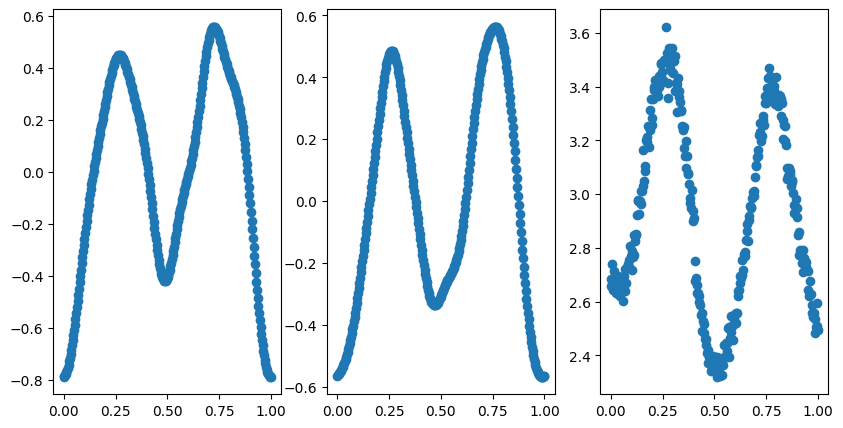

In [66]:
import matplotlib.pyplot as plt

l2 = dp._fourier8(t, 0, *list(dp.data[DataType.FS][0][1:]))
l3 = dp.data[DataType.LC][0]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))


ax[0].scatter(t, l1)
ax[1].scatter(t, l2)
ax[2].scatter(t, l3)


In [60]:
dp.data[DataType.LC][0].shape, dp.data["labels"][0]

((300,), 0)

In [67]:
import pandas as pd

RB_NAMES =   ["CZ-3B", "Falcon 9", "Atlas 5 Centaur",  "H2-A", "Ariane 5", "Delta 4", "Titan 3"]
RB_REGEXES = [r'CZ-3B.*', r'FALCON_9.*', r'ATLAS_[5|V]_CENTAUR_R.B$',  
             r'H-2A.*', r'ARIANE_5.*', r'DELTA_4.*', r'TITAN_3C_TRANSTAGE.*']

t = np.linspace(0,1,300)

file_names = ["CZ_3B_R|B", "FALCON_9_R|B", "ATLAS_5_CENTAUR_R|B", "H-2A_R|B", "ARIANE_5_R|B", "DELTA_4_R|B", "TITAN_3C_TRANSTAGE_R.B"]

for i in range(len(RB_NAMES)):

    x = X_new[y_new == i]
    object_id = i*2000 + np.arange(N)
    track_id = np.arange(N) + i*2000
    phase = np.ones(N)
    lcs = np.array([dp._fourier8(t, 0, *list(fc)) for fc in x])
    data = np.column_stack([object_id, track_id, phase, lcs])
    df = pd.DataFrame(data, columns=["object_id", "track_id", "phase"] + [str(i) for i in range(lcs.shape[1])])
    df.to_csv(f"{PACKAGE_PATH}/artificial_hist/{file_names[i]}.csv", index=False)